Here's where we left off last time

In [6]:
%load_ext autoreload
%autoreload 2

from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%reload_ext autoreload

In [8]:
from ibd.three.complete import *
from ibd.three.handshake import handshake
import time
import pprint

runs = []


def simple_crawler():
    addresses = [
        ("91.221.70.137", 8333),
        ("92.255.176.109", 8333),
        ("35.198.151.21", 8333),
        ("94.199.178.17", 8333),
        ("77.98.116.8", 8333),
    ]
    global times
    while addresses:
        pprint.pprint(addresses)
        start = time.time()
        address = addresses.pop()
        print('connecting to ', address)
        
        try:
            sock = handshake(address, log=True)
        except Exception as e:
            print(e)
            runs.append((address, start, time.time(), 'handshake-failure'))
            continue
            
        print("Waiting for addr message")
        listening = True
        while listening:
            try:
                packet = Packet.from_socket(sock)
            except EOFError as e:
                print(e)
                runs.append((address, start, time.time(), 'addr-failure'))
                break
            if packet.command == b"addr":
                addr_message = AddrMessage.from_bytes(packet.payload)
                if len(addr_message.addresses) == 1 and addr_message.addresses[0].ip == address[0]:
                    print("Received addr message with only our peer's address. Still waiting ...")
                else:
                    print(f"Received {len(addr_message.addresses)} addrs")
                    addresses.extend([(a.ip, a.port) for a in addr_message.addresses])
                    runs.append((address, start, time.time(), 'success'))
                    listening = False
    print("ran out of addresses. exiting.")

In [9]:
simple_crawler()

[('91.221.70.137', 8333),
 ('92.255.176.109', 8333),
 ('35.198.151.21', 8333),
 ('94.199.178.17', 8333),
 ('77.98.116.8', 8333)]
connecting to  ('77.98.116.8', 8333)
+------------------+---------------------------------+
| VersionMessage   |                                 |
+==================+=================================+
| version          | 70015                           |
+------------------+---------------------------------+
| services         | 1037                            |
+------------------+---------------------------------+
| time             | 1540983609                      |
+------------------+---------------------------------+
| addr_recv        | <Address 109.224.219.196:52457> |
+------------------+---------------------------------+
| addr_from        | <Address :::0>                  |
+------------------+---------------------------------+
| nonce            | 3913638318729335281             |
+------------------+---------------------------------+
| user_ag

+------------------+---------------------------------+
| VersionMessage   |                                 |
+==================+=================================+
| version          | 70015                           |
+------------------+---------------------------------+
| services         | 13                              |
+------------------+---------------------------------+
| time             | 1540984188                      |
+------------------+---------------------------------+
| addr_recv        | <Address 109.224.219.196:52590> |
+------------------+---------------------------------+
| addr_from        | <Address :::0>                  |
+------------------+---------------------------------+
| nonce            | 16876905347705094892            |
+------------------+---------------------------------+
| user_agent       | b'/Satoshi:0.15.1/'             |
+------------------+---------------------------------+
| start_height     | 548118                          |
+---------

[Errno 60] Operation timed out
[('91.221.70.137', 8333),
 ('92.255.176.109', 8333),
 ('35.198.151.21', 8333),
 ('94.199.178.17', 8333),
 ('34.201.171.216', 8338),
 ('40.74.80.66', 8333),
 ('85.214.99.235', 8333),
 ('104.199.160.111', 8333),
 ('34.219.171.130', 8333),
 ('192.169.1.158', 8333)]
connecting to  ('192.169.1.158', 8333)
[Errno 60] Operation timed out
[('91.221.70.137', 8333),
 ('92.255.176.109', 8333),
 ('35.198.151.21', 8333),
 ('94.199.178.17', 8333),
 ('34.201.171.216', 8338),
 ('40.74.80.66', 8333),
 ('85.214.99.235', 8333),
 ('104.199.160.111', 8333),
 ('34.219.171.130', 8333)]
connecting to  ('34.219.171.130', 8333)
+------------------+---------------------------------+
| VersionMessage   |                                 |
+==================+=================================+
| version          | 70015                           |
+------------------+---------------------------------+
| services         | 1037                            |
+------------------+---------

KeyboardInterrupt: 

This code is nothing to write home about, but it does something very cool: it crawls the Bitcoin network!

It maintains a list of addresses and uses them as a sort of "queue". It pops addresses off the end of the list and tries to connect to them and do the version handshake. Upon a successful version handshake, it continues listening until it receives an ["addr" message ](https://en.bitcoin.it/wiki/Protocol_documentation#addr). It checks if there there `addr` message contains any addresses we don't yet know about. If it does, it adds them to its `addresses` list 

It also keeps track of the start time, stop time and outcome of every loop in the `times` global variable. I made this a global variable so that we can kill the script and still have access to this data afterwards.

Here is what the output looked like after running the script for about 7 minutes:

```
connecting to  ('213.250.21.112', 8333)
Waiting for addr message
Received 1 addrs
connecting to  ('2a00:ee2:1200:1900:20c:29ff:fe45:9554', 8333)
[Errno -9] Address family for hostname not supported
connecting to  ('94.199.178.17', 8333)
Waiting for addr message
Received addr message with only our peer's address. Still waiting ...
Received 1 addrs
connecting to  ('87.110.120.221', 8333)
Waiting for addr message
Received addr message with only our peer's address. Still waiting ...
Received 1 addrs
connecting to  ('213.155.3.216', 8333)
Waiting for addr message
Received addr message with only our peer's address. Still waiting ...
Failed to recover from bad magic bytes
connecting to  ('35.198.151.21', 8333)
Waiting for addr message
Received addr message with only our peer's address. Still waiting ...
Failed to recover from bad magic bytes
connecting to  ('92.255.176.109', 8333)
Waiting for addr message
Received addr message with only our peer's address. Still waiting ...
Received 1 addrs
connecting to  ('80.211.252.169', 8333)
Waiting for addr message
Received addr message with only our peer's address. Still waiting ...
Received 2 addrs
connecting to  ('185.150.189.51', 8333)
Waiting for addr message
Received addr message with only our peer's address. Still waiting ...
```

Here is what `runs` looked like:

In [10]:
pprint.pprint(runs)

[(('77.98.116.8', 8333), 1540983609.221411, 1540983626.1459851, 'success'),
 (('68.77.250.206', 8333), 1540983626.146355, 1540983690.712677, 'success'),
 (('128.199.222.83', 8333), 1540983690.7131321, 1540983757.5073762, 'success'),
 (('47.252.13.4', 3005),
  1540983757.5079591,
  1540983832.784054,
  'handshake-failure'),
 (('211.237.13.24', 8333), 1540983832.7846222, 1540984029.942711, 'success'),
 (('185.30.116.178', 8333),
  1540984029.943228,
  1540984105.283882,
  'handshake-failure'),
 (('62.210.162.89', 8333), 1540984105.285256, 1540984186.4563851, 'success'),
 (('112.74.50.226', 8333),
  1540984186.457082,
  1540984193.790689,
  'addr-failure'),
 (('104.199.160.111', 8333), 1540984193.791431, 1540984246.944435, 'success'),
 (('94.23.250.222', 9444), 1540984246.9463701, 1540984289.505195, 'success'),
 (('94.130.47.134', 8333), 1540984289.505793, 1540984337.740371, 'success'),
 (('153.125.129.187', 8333), 1540984337.741031, 1540984359.8442822, 'success'),
 (('203.150.176.56', 83

* We successfully downloaded `addr` messages from 5 peers
* We successfully executed the version handshake but failed to download `addr` messages from 2 peers
* We failed to execute version handshake with 1 peer

In [11]:
Counter([run[3] for run in runs])

Counter({'success': 11, 'handshake-failure': 5, 'addr-failure': 3})

Here's a calculation to see the average duration per successful request:

In [12]:
first_task_start = runs[0][1]
last_task_end = runs[-1][2]
duration = last_task_end - first_task_start
num_successful_tasks = len([run for run in runs if run[3] == "success"])
duration / num_successful_tasks

89.71744563362815

So ... 90 seconds per Bitcoin peer ... that's rough ...

As I write this, Bitnodes says there are 9803 peers in the network. At this pace it would take about 10 days to crawl the entire network:

In [14]:
estimated_duration = 9803 * 90
seconds_per_day = 60 * 60 * 24 
estimated_duration / seconds_per_day

10.211458333333333

So why is our program so slow?

In order to improve our lot, we first need to understand _why_ our code is slow. Analyzing the speed of a program is one aspect of the discipline of ["profiling"](https://en.wikipedia.org/wiki/Profiling_(computer_programming)).

To profile our slow code and understand figure out why it's so slow, we're going to use a tool called [line_profiler](https://github.com/rkern/line_profiler/). [Here is a nice tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) that describes a few methods of profiling python code, including line_profiler. Please read it.

To use `version_profiler` we first, we load line_profiler as an Jupyter extension. Next, we run our ` simple_crawler` function through it:

In [15]:
# had to install to venv using
# pip install git+https://github.com/rkern/line_profiler.git
# as python 3.7 has broken something

%load_ext line_profiler
%lprun -f simple_crawler simple_crawler()

[('91.221.70.137', 8333),
 ('92.255.176.109', 8333),
 ('35.198.151.21', 8333),
 ('94.199.178.17', 8333),
 ('77.98.116.8', 8333)]
connecting to  ('77.98.116.8', 8333)
+------------------+---------------------------------+
| VersionMessage   |                                 |
+==================+=================================+
| version          | 70015                           |
+------------------+---------------------------------+
| services         | 1037                            |
+------------------+---------------------------------+
| time             | 1540984675                      |
+------------------+---------------------------------+
| addr_recv        | <Address 109.224.219.196:52660> |
+------------------+---------------------------------+
| addr_from        | <Address :::0>                  |
+------------------+---------------------------------+
| nonce            | 15067576239586100990            |
+------------------+---------------------------------+
| user_ag

Here's the result I got after running this for 93 seconds.

We're spending 98.8% of the time on the `packet = Packet.from_socket(sock)` line of code, the remaining 1.2% of the time on the `sock = handshake(address, log=False)` line of code, and virtually zero time anywhere else.

This makes sense. From previous classes we say that the version handshake takes less than 1 second. If we're averaging only one or two "runs" through our loop per minute, then most of the time is spent elsewhere. When we print out every message we receive it is clear that most of the time is spent waiting for our peer to send us messages, which happens in the `packet = Packet.from_socket(sock)` line.

All this time is spent on the blocking `sock.recv` lines within `Packet.from_socket`.

```
Timer unit: 1e-06 s

Total time: 93.1451 s
File: <ipython-input-10-06eed22ae057>
Function: simple_crawler at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     9                                           def simple_crawler():
    10                                               addresses = [
    11         1          3.0      3.0      0.0          ("91.221.70.137", 8333),
    12         1          2.0      2.0      0.0          ("92.255.176.109", 8333),
    13         1          1.0      1.0      0.0          ("35.198.151.21", 8333),
    14         1          1.0      1.0      0.0          ("94.199.178.17", 8333),
    15         1          1.0      1.0      0.0          ("213.250.21.112", 8333),
    16                                               ]
    17                                               global times
    18         5         30.0      6.0      0.0      while addresses:
    19         5         35.0      7.0      0.0          start = time.time()
    20         5         31.0      6.2      0.0          address = addresses.pop()
    21         5       1612.0    322.4      0.0          print('connecting to ', address)
    22                                                   
    23         5         29.0      5.8      0.0          try:
    24         5    1135411.0 227082.2      1.2              sock = handshake(address, log=False)
    25         2         25.0     12.5      0.0          except Exception as e:
    26         2        521.0    260.5      0.0              print(e)
    27         2         31.0     15.5      0.0              times.append((start, time.time(), 'failure'))
    28         2       1090.0    545.0      0.0              continue
    29                                                       
    30         3       1165.0    388.3      0.0          print("Waiting for addr message")
    31         3         20.0      6.7      0.0          listening = True
    32        35        181.0      5.2      0.0          while listening:
    33        33        152.0      4.6      0.0              try:
    34        33   92001983.0 2787938.9     98.8                  packet = Packet.from_socket(sock)
    35         1         15.0     15.0      0.0              except EOFError as e:
    36                                                           print(e)
    37                                                           times.append((start, time.time(), 'failure'))
    38                                                           break
    39        32        310.0      9.7      0.0              if packet.command == b"addr":
    40         4        776.0    194.0      0.0                  addr_message = AddrMessage.from_bytes(packet.payload)
    41         4         48.0     12.0      0.0                  if len(addr_message.addresses) == 1 and addr_message.addresses[0].ip == address[0]:
    42         2        658.0    329.0      0.0                      print("Received addr message with only our peer's address. Still waiting ...")
    43                                                           else:
    44         2        848.0    424.0      0.0                      print(f"Received {len(addr_message.addresses)} addrs")
    45         2         53.0     26.5      0.0                      addresses.extend([(a.ip, a.port) for a in addr_message.addresses])
    46         2         29.0     14.5      0.0                      times.append((start, time.time(), 'success'))
    47         2         13.0      6.5      0.0                      listening = False
    48                                               print("ran out of addresses. exiting.")
```

Next, let's plot the execution of our program's loops

In [16]:
start_stop = [
    (run[1], run[2]) for run in runs
]
start_stop

[(1540983609.221411, 1540983626.1459851),
 (1540983626.146355, 1540983690.712677),
 (1540983690.7131321, 1540983757.5073762),
 (1540983757.5079591, 1540983832.784054),
 (1540983832.7846222, 1540984029.942711),
 (1540984029.943228, 1540984105.283882),
 (1540984105.285256, 1540984186.4563851),
 (1540984186.457082, 1540984193.790689),
 (1540984193.791431, 1540984246.944435),
 (1540984246.9463701, 1540984289.505195),
 (1540984289.505793, 1540984337.740371),
 (1540984337.741031, 1540984359.8442822),
 (1540984359.8449202, 1540984435.116297),
 (1540984435.117186, 1540984510.352926),
 (1540984510.353515, 1540984511.287149),
 (1540984511.2876642, 1540984548.887618),
 (1540984548.8881521, 1540984549.203989),
 (1540984549.20468, 1540984596.110204),
 (1540984596.110964, 1540984596.113313)]

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_runtimes(results):
    start,stop = np.array(results).T
    plt.barh(range(len(start)), stop-start, left=start)
    plt.grid(axis="x")
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")

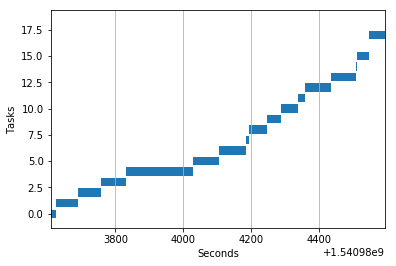

In [18]:
visualize_runtimes(start_stop)

Every bar in this graph represents a connection to some peer on the bitcoin network. 

First, notice that some bars seem to be missing, or slice thin. These are the graphs with errors. We can demonstrate this by filtering out the tasks that weren't recorded as "success":

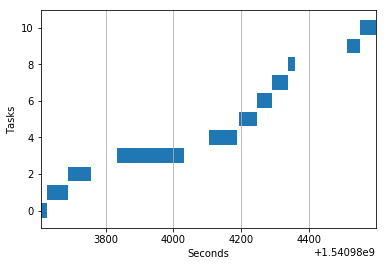

In [19]:
success_start_stop = [
    (run[1], run[2]) for run in runs if run[-1] == 'success'
]
visualize_runtimes(success_start_stop)

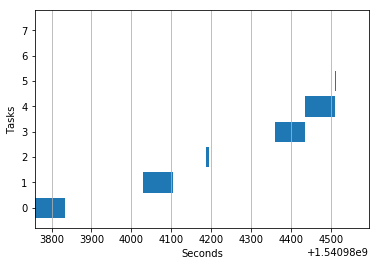

In [20]:
fail_start_stop = [
    (run[1], run[2]) for run in runs if run[-1] != 'success'
]
visualize_runtimes(fail_start_stop)

So here's our problem:
* We're only able to communicate to 1 peer at a time, as demonstrated by the graphs above
* When communicating with a peer, approximately 98% of the time is spent waiting for the peer to send us a response.

What if we were able to communicate with more than one peer at a time? While one connection is waiting another could actually busy themselves with interpreting an incoming message and responsing to it if appropriate.

If 98% of the time is spent waiting, we could in theory achieve at least a 50x speedup by doing this.